# A testing ground for pyPIPS functionality

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.polarimetric as dualpol
#from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
from pyCRMtools.pycaps import arps_read
from pyCRMtools.pycaps import pycaps_fields
from pyCRMtools.pycaps import calvars_radar as radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
from natsort import natsorted
from pprint import pprint

def remove_unneeded(ds):
    dim_names_to_remove = ['fields_KHTX', 'fields_KGWX', 'fields']
    ds = ds.drop_dims(dim_names_to_remove, errors='ignore')
    return ds
#

PIPS_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/full_PIPS_dataset'
parsivel_filenames = glob.glob(PIPS_dir + '/parsivel_combined*60s*nc')
parsivel_filenames = natsorted(parsivel_filenames)
#parsivel_ds = xr.open_dataset(parsivel_filenames[0])
#print(len(parsivel_filenames))
#pprint([os.path.basename(f) for f in parsivel_filenames])
parsivel_ds = xr.open_mfdataset(parsivel_filenames, preprocess=remove_unneeded) #, combine='nested', concat_dim='time')
#pprint(parsivel_filenames[34:])
#parsivel_filename = 'parsivel_combined_FMCW_2017_043017_PIPS2A_60s.nc'
#PIPS_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/TriPIPS/2019'
#parsivel_filename = 'parsivel_combined_TriPIPS_092719_TriPIPS_10s.nc'
#parsivel_filepath = os.path.join(PIPS_dir, parsivel_filename)
#parsivel_ds = xr.open_dataset(parsivel_filepath)
print(parsivel_ds)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  app.launch_new_instance()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


<xarray.Dataset>
Dimensions:            (diameter_bin: 32, fallspeed_bin: 32, parameter: 3, time: 68505)
Coordinates:
    min_fallspeeds     (fallspeed_bin) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    max_diameter       (diameter_bin) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    max_fallspeeds     (fallspeed_bin) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    diameter           (diameter_bin) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    fallspeed          (fallspeed_bin) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    min_diameter       (diameter_bin) float64 dask.array<chunksize=(32,), meta=np.ndarray>
  * parameter          (parameter) object 'N0' 'lamda' 'alpha'
  * time               (time) datetime64[ns] 2017-03-24T16:58:20 ... 2016-05-01T15:35:13
Dimensions without coordinates: diameter_bin, fallspeed_bin
Data variables:
    precipintensity    (time) float64 dask.array<chunksize=(423,), meta=np.ndarray>
    precipaccum      

In [47]:
parsivel_filtered_ds = parsivel_ds.where((parsivel_ds['pcount'] >= 100) & (parsivel_ds['precipintensity'] > 1.), drop=True)
ND = parsivel_filtered_ds['ND_qc']
ND_retr = parsivel_filtered_ds['ND_retr']
D0 = dsd.calc_D0_bin(ND.load()) * 1000.
D0_retr = dsd.calc_D0_bin(ND_retr.load()) * 1000.
RR_obs = parsivel_filtered_ds['precipintensity']
D0_ds = xr.Dataset({'D0_obs': D0, 'D0_retr': D0_retr, 'RR_obs': RR_obs})
print(D0_ds)

<xarray.Dataset>
Dimensions:  (time: 3644)
Coordinates:
  * time     (time) datetime64[ns] 2017-03-25T21:52:00 ... 2016-04-30T22:25:13
Data variables:
    D0_obs   (time) float64 1.056 1.452 1.829 1.495 ... 3.729 3.076 3.224 2.055
    D0_retr  (time) float64 1.17 1.576 1.615 1.357 ... nan 2.177 2.464 1.947
    RR_obs   (time) float64 dask.array<chunksize=(47,), meta=np.ndarray>


(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbfedd78350>)

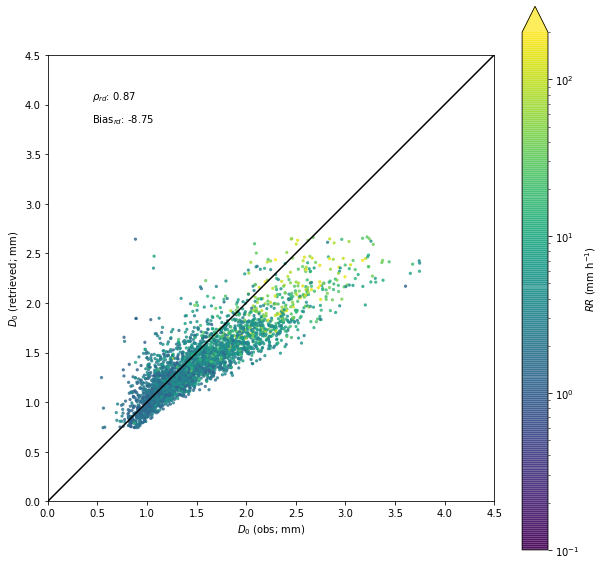

In [48]:
import matplotlib.colors as colors
axparams = {
    'var_lims': [[0.0, 4.5], [0.0, 4.5]],
    'col_field': 'RR_obs',
    'col_field_lims': [0.1, 200.],
    'norm': colors.LogNorm(vmin=0.1, vmax=200.),
    'alpha': 0.75,
    'markersize': 5,
    'label_x': r'$D_0$ (obs; mm)',
    'label_y': r'$D_0$ (retrieved; mm)',
    'label_cb': r'$RR$ (mm h$^{-1}$)'
}
PIPSplot.plot_one2one(D0_ds, 'D0_obs', 'D0_retr', axparams)

In [56]:
D0 = dsd.calc_D0_bin(ND.load()) * 1000.
dualpol_dict = dualpol.calpolrain(10.7, '/Users/dawson29/Projects/pyPIPS/tmatrix/S-Band/SCTT_RAIN_fw100.dat',
                                  ND, dD)
ZDR = dualpol_dict['ZDR']
overlap = (D0 > 0.) & (ZDR > 0.)
D0 = D0.where(overlap)
ZDR = ZDR.where(overlap)
RR_obs = RR_obs.where(overlap)

D0_ds = xr.Dataset({'D0': D0, 'ZDR': ZDR, 'RR_obs': RR_obs})

D0_vals = D0.values
ZDR_vals = ZDR.values

goodindices = np.isfinite(D0_vals) & np.isfinite(ZDR_vals)
D0_vals = D0_vals[goodindices]
ZDR_vals = ZDR_vals[goodindices]

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


[ 0.8220966   0.69164976  0.08972063 -0.03404272]


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


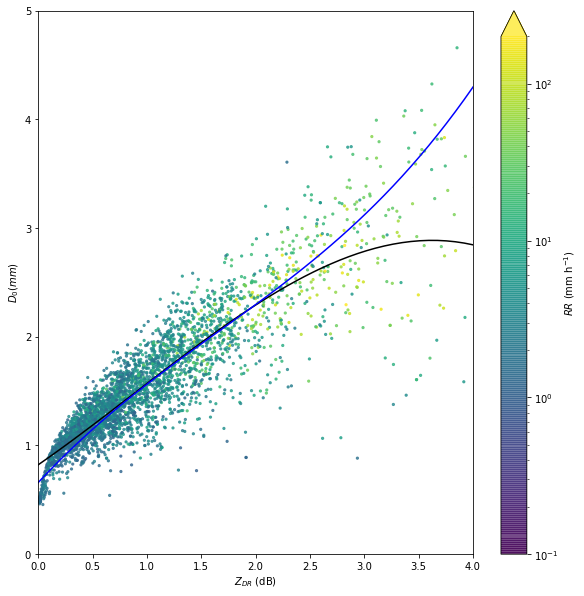

In [58]:

axparams = {
    'var_lims': [[0., 4.], [0., 5.]],
    'plot_log': [False, False],
    'col_field': 'RR_obs',
    'col_field_lims': [0.1, 200.],
    'norm': colors.LogNorm(vmin=0.1, vmax=200.),
    'alpha': 0.75,
    'markersize': 5,
    'label_x': r'$Z_{DR}$ (dB)',
    'label_y': r'$D_0 (mm)$', 
    'label_cb': r'$RR$ (mm h$^{-1}$)'
}
fig, ax = PIPSplot.plot_scatter(D0_ds, 'ZDR', 'D0', axparams)
poly_coeff, poly = dsd.calc_empirical_polyfit(ZDR_vals, D0_vals, order=3)
print(poly_coeff)

xx = np.linspace(0., 4.)
yy = poly(xx)
ax.plot(xx, yy, 'k')

D0_cao = 0.0436 * (xx**3.) - 0.216 * (xx**2.) + 1.076 * xx + 0.659
ax.plot(xx, D0_cao, 'b')

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/Users/dawson29

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbfea472190>)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


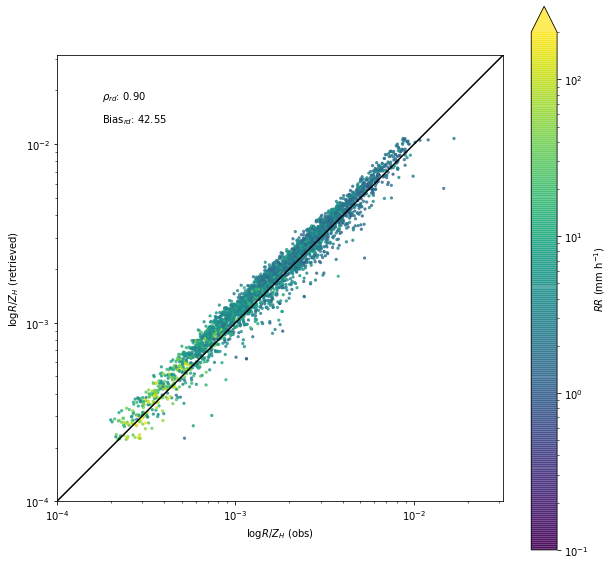

In [49]:
RR_obs = dsd.calc_rainrate_from_bins(ND)
RR_retr = parsivel_filtered_ds['RR_retr']
overlap = (RR_obs > 0.) & (RR_retr > 0.)
RR_obs = RR_obs.where(overlap)
RR_retr = RR_retr.where(overlap)
dD = ND['max_diameter'] - ND['min_diameter']
dualpol_dict = dualpol.calpolrain(10.7, '/Users/dawson29/Projects/pyPIPS/tmatrix/S-Band/SCTT_RAIN_fw100.dat',
                                  ND, dD)
ZH = dualpol_dict['ZH']
ZH = ZH.where(ZH > 0.)
RRdZH_obs = RR_obs/ZH
RRdZH_retr = RR_retr/ZH

RRdZH_ds = xr.Dataset({'RRdZH_obs': RRdZH_obs, 'RRdZH_retr': RRdZH_retr, 'RR_obs': RR_obs})

axparams = {
    'var_lims': [[-4., -1.5], [-4., -1.5]],
    'plot_log': [True, True],
    'col_field': 'RR_obs',
    'col_field_lims': [0.1, 200.],
    'norm': colors.LogNorm(vmin=0.1, vmax=200.),
    'alpha': 0.75,
    'markersize': 5,
    'label_x': r'$\log{R/Z_H}$ (obs)',
    'label_y': r'$\log{R/Z_H}$ (retrieved)',
    'label_cb': r'$RR$ (mm h$^{-1}$)'
}
PIPSplot.plot_one2one(RRdZH_ds, 'RRdZH_obs', 'RRdZH_retr', axparams)

In [50]:
RR_obs = dsd.calc_rainrate_from_bins(ND)
dD = ND['max_diameter'] - ND['min_diameter']
dualpol_dict = dualpol.calpolrain(10.7, '/Users/dawson29/Projects/pyPIPS/tmatrix/S-Band/SCTT_RAIN_fw100.dat',
                                  ND, dD)
ZH = dualpol_dict['ZH']
ZH = ZH.where(ZH > 0.)
RRdZH_obs = RR_obs/ZH
ZDR = dualpol_dict['ZDR']
overlap = (RRdZH_obs > 0.) & (ZDR > 0.)
RRdZH_obs = RRdZH_obs.where(overlap)
ZDR = ZDR.where(overlap)

RRdZH_ZDR_ds = xr.Dataset({'RRdZH': RRdZH_obs, 'ZDR': ZDR, 'RR_obs': RR_obs})

RRdZH_vals = RRdZH_obs.values
log_RRdZH_vals = np.log10(RRdZH_vals)
ZDR_vals = ZDR.values

goodindices = np.isfinite(log_RRdZH_vals) & np.isfinite(ZDR_vals)
log_RRdZH_vals = log_RRdZH_vals[goodindices]
ZDR_vals = ZDR_vals[goodindices]

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


In [51]:
from scipy.optimize import curve_fit
def func(x, a, b, c, d):
    return a*x**3. + b*x**2. + c*x + d

popt, pcov = curve_fit(func, ZDR_vals, log_RRdZH_vals)
print(popt)

# Gives almost the same results (reversed coefficient order...)

[-0.04908661  0.40219229 -1.2909573  -1.96262518]


[-1.96262518 -1.2909573   0.40219229 -0.04908661]


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  fig.canvas.print_figure(bytes_io, **kw)


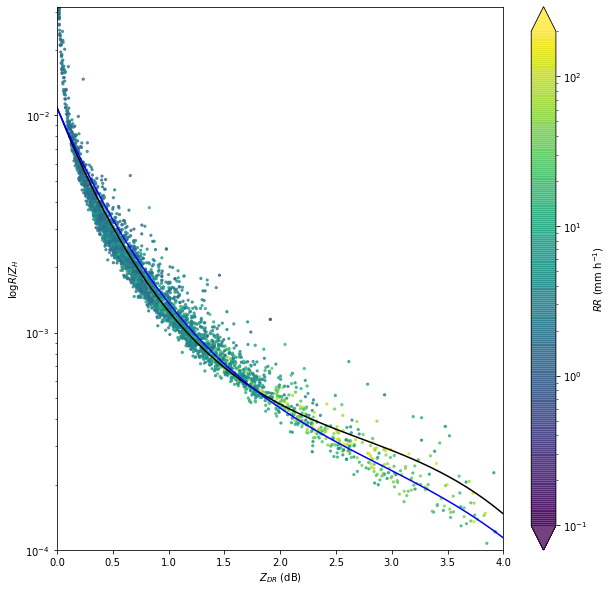

In [52]:

axparams = {
    'var_lims': [[0., 4.], [-4., -1.5]],
    'plot_log': [False, True],
    'col_field': 'RR_obs',
    'col_field_lims': [0.1, 200.],
    'norm': colors.LogNorm(vmin=0.1, vmax=200.),
    'alpha': 0.75,
    'markersize': 5,
    'label_x': r'$Z_{DR}$ (dB)',
    'label_y': r'$\log{R/Z_H}$', 
    'label_cb': r'$RR$ (mm h$^{-1}$)'
}
fig, ax = PIPSplot.plot_scatter(RRdZH_ZDR_ds, 'ZDR', 'RRdZH', axparams)
poly_coeff, poly = dsd.calc_empirical_polyfit(ZDR_vals, log_RRdZH_vals, order=3)
print(poly_coeff)

xx = np.linspace(0., 4.)
yy = poly(xx)
ax.plot(xx, 10.**yy, 'k')

RdZH_cao = 10.**(-0.0363 * (xx**3.) + 0.316 * (xx**2.) - 1.178 * xx - 1.964)
ax.plot(xx, RdZH_cao, 'b')

(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbfb8b67050>)

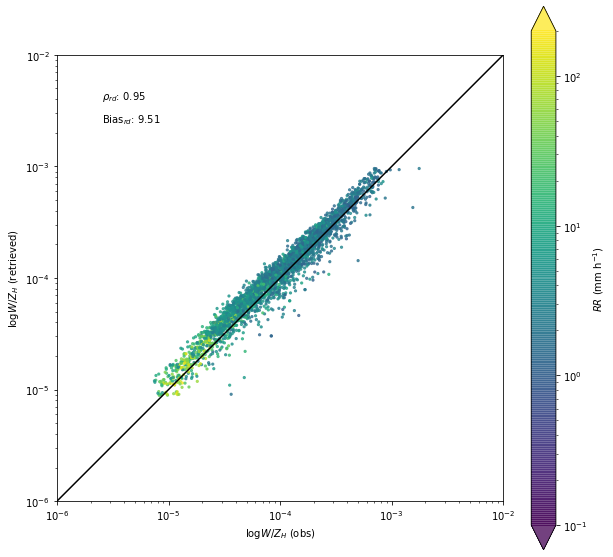

In [53]:
W_obs, _ = dsd.calc_lwc_qr_from_bins(ND, parsivel_filtered_ds['rho'])
W_obs = W_obs * 1000.
W_retr, _ = dsd.calc_lwc_qr_from_bins(ND_retr, parsivel_filtered_ds['rho']) # parsivel_ds['W_retr']
W_retr = W_retr * 1000.
overlap = (W_obs > 0.) & (W_retr > 0.)
W_obs = W_obs.where(overlap)
W_retr = W_retr.where(overlap)
dD = ND['max_diameter'] - ND['min_diameter']

WdZH_obs = W_obs/ZH
WdZH_retr = W_retr/ZH
WdZH_ds = xr.Dataset({'WdZH_obs': WdZH_obs, 'WdZH_retr': WdZH_retr, 'RR_obs': RR_obs})

axparams = {
    'var_lims': [[-6., -2.], [-6, -2.]],
    'plot_log': [True, True],
    'col_field': 'RR_obs',
    'col_field_lims': [0.1, 200.],
    'norm': colors.LogNorm(vmin=0.1, vmax=200.),
    'alpha': 0.75,
    'markersize': 5,
    'label_x': r'$\log{W/Z_H}$ (obs)',
    'label_y': r'$\log{W/Z_H}$ (retrieved)',
    'label_cb': r'$RR$ (mm h$^{-1}$)'
}
PIPSplot.plot_one2one(WdZH_ds, 'WdZH_obs', 'WdZH_retr', axparams)

In [54]:
W_obs, _ = dsd.calc_lwc_qr_from_bins(ND, parsivel_filtered_ds['rho'])
W_obs = W_obs * 1000.
overlap = (W_obs > 0.)
W_obs = W_obs.where(overlap)
#W_obs = dsd.calc_rainrate_from_bins(ND)
dD = ND['max_diameter'] - ND['min_diameter']
dualpol_dict = dualpol.calpolrain(10.7, '/Users/dawson29/Projects/pyPIPS/tmatrix/S-Band/SCTT_RAIN_fw100.dat',
                                  ND, dD)
ZH = dualpol_dict['ZH']
ZH = ZH.where(ZH > 0.)
WdZH_obs = W_obs/ZH
ZDR = dualpol_dict['ZDR']
overlap = (WdZH_obs > 0.) & (ZDR > 0.)
WdZH_obs = WdZH_obs.where(overlap)
ZDR = ZDR.where(overlap)

WdZH_ZDR_ds = xr.Dataset({'WdZH': WdZH_obs, 'ZDR': ZDR, 'RR_obs': RR_obs})

WdZH_vals = WdZH_obs.values
log_WdZH_vals = np.log10(WdZH_vals)
ZDR_vals = ZDR.values

goodindices = np.isfinite(log_WdZH_vals) & np.isfinite(ZDR_vals)
log_WdZH_vals = log_WdZH_vals[goodindices]
ZDR_vals = ZDR_vals[goodindices]

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


[-3.02306591 -1.58544356  0.492001   -0.05813522]


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  fig.canvas.print_figure(bytes_io, **kw)


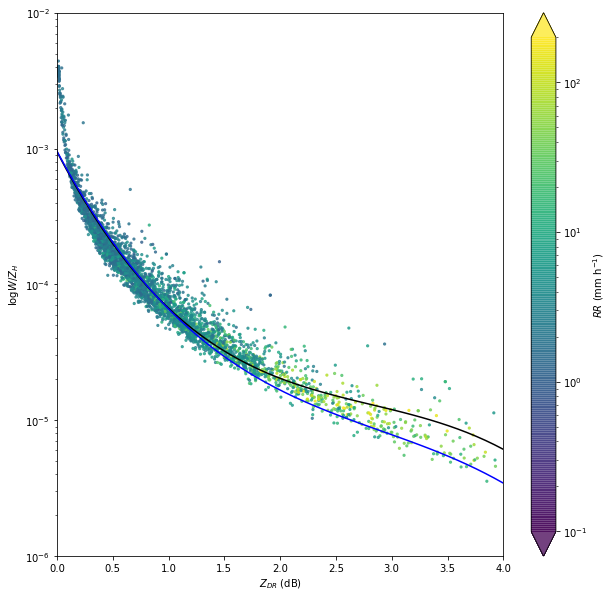

In [55]:

axparams = {
    'var_lims': [[0., 4.], [-6., -2.]],
    'plot_log': [False, True],
    'col_field': 'RR_obs',
    'col_field_lims': [0.1, 200.],
    'norm': colors.LogNorm(vmin=0.1, vmax=200.),
    'alpha': 0.75,
    'markersize': 5,
    'label_x': r'$Z_{DR}$ (dB)',
    'label_y': r'$\log{W/Z_H}$', 
    'label_cb': r'$RR$ (mm h$^{-1}$)'
}
fig, ax = PIPSplot.plot_scatter(WdZH_ZDR_ds, 'ZDR', 'WdZH', axparams)
poly_coeff, poly = dsd.calc_empirical_polyfit(ZDR_vals, log_WdZH_vals, order=3)
print(poly_coeff)

xx = np.linspace(0., 4.)
yy = poly(xx)
ax.plot(xx, 10.**yy, 'k')
WdZH_cao = 10.**(-0.0493 * (xx**3.) + 0.430 * (xx**2.) - 1.542 * xx - 3.019)
ax.plot(xx, WdZH_cao, 'b')

In [ ]:
Nt_obs = dsd.calc_NT_from_bins(ND)
Nt_retr = dsd.calc_NT_from_bins(ND_retr) # parsivel_ds['Nt_retr']
overlap = (Nt_obs > 0.) & (Nt_retr > 0.)
Nt_obs = Nt_obs.where(overlap)
Nt_retr = Nt_retr.where(overlap)
dD = ND['max_diameter'] - ND['min_diameter']

NtdZH_obs = Nt_obs/ZH
NtdZH_retr = Nt_retr/ZH

NtdZH_ds = xr.Dataset({'NtdZH_obs': NtdZH_obs, 'NtdZH_retr': NtdZH_retr, 'RR_obs': RR_obs})

axparams = {
    'var_lims': [[-3., 2.], [-3., 2.]],
    'plot_log': [True, True],
    'col_field': 'RR_obs',
    'col_field_lims': [0.1, 200.],
    'norm': colors.LogNorm(vmin=0.1, vmax=200.),
    'alpha': 0.75,
    'markersize': 5,
    'label_x': r'$\log{N_T/Z_H}$ (obs)',
    'label_y': r'$\log{N_T/Z_H}$ (retrieved)',
    'label_cb': r'$RR$ (mm h$^{-1}$)'
}
PIPSplot.plot_one2one(NtdZH_ds, 'NtdZH_obs', 'NtdZH_retr', axparams)

In [ ]:
parsivel_ds.close()

In [ ]:
from pprint import pprint
def roundPartial (value, resolution):
    return round(value / resolution) * resolution


# Test reading of lookup table
D0_lookup = pd.read_csv('/Users/dawson29/Projects/pyPIPS/data/lookups/D0.csv', sep=',', header=0, 
                        index_col='dBZ')
# print(D0_lookup)
# print(D0_lookup.index[1]-D0_lookup.index[0])
# print(float(D0_lookup.columns[1])-float(D0_lookup.columns[0]))

D0_lookup.index = D0_lookup.index.to_series().apply(np.around, decimals=4)

D0_lookup.columns = [np.float(col) for col in D0_lookup.columns]
D0_lookup.columns = [np.around(col, decimals=4) for col in D0_lookup.columns]

pprint(D0_lookup.index.tolist())
pprint(D0_lookup.columns.tolist())

dBZ = np.around(roundPartial(dBZval, 0.1), decimals=4)
ZDR = roundPartial(ZDRval, 0.01)

dBZ_vals = np.arange(10., 70., 10.).reshape(3, 2)
dBZ_vals = np.ma.masked_where(dBZ_vals == 40., dBZ_vals)
mask = dBZ_vals.mask
print(dBZ_vals)
print(mask)
shape = dBZ_vals.shape
ZDR_vals = np.arange(0.5, 3.5, 0.5).reshape(3, 2)
#print(ZDR_vals.astype('str'))

D0_retr_vals = D0_lookup.lookup(dBZ_vals.flatten(), ZDR_vals.flatten())
D0_retr_vals = D0_retr_vals.reshape(shape)
D0_retr_vals = np.ma.masked_where(mask, D0_retr_vals)

print(dBZ_vals.flatten())
print(D0_retr_vals)

print(min(D0_lookup.index))
print(D0_lookup.index[0])
print(D0_lookup.columns[-1])

In [ ]:
Dm = parsivel_ds['Dm43'] * 1000.
Dm_retr = parsivel_ds['Dm_retr']
Dm.plot(ylim=[0., 4.5], color='b')
Dm_retr.plot(ylim=[0., 4.5], color='g')

In [ ]:
dD = ND['max_diameter'] - ND['min_diameter']
dualpol_dict = dualpol.calpolrain(10.7, '/Users/dawson29/Projects/pyPIPS/tmatrix/S-Band/SCTT_RAIN_fw100.dat',
                                  ND, dD)
dBZ = dualpol_dict['REF']
dualpol_dict_retr = dualpol.calpolrain(10.7, '/Users/dawson29/Projects/pyPIPS/tmatrix/S-Band/SCTT_RAIN_fw100.dat',
                                       ND_retr, dD)
dBZ_retr = dualpol_dict_retr['REF']

dBZ.plot(color='b', ylim=[0., 60.])
dBZ_retr.plot(color='g')

In [ ]:
ZDR = dualpol_dict['ZDR']
ZDR_retr = dualpol_dict_retr['ZDR']

ZDR.plot(color='b')
ZDR_retr.plot(color='g')

In [ ]:
RR = parsivel_ds['precipintensity']
RR_retr = parsivel_ds['RR_retr']
RR.plot(color='b')
RR_retr.plot(color='g')

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(RR, RR_retr)
ax.plot(np.linspace(0., 60., num=100), np.linspace(0., 60., num=100))
ax.set_xlim(0., 60.)
ax.set_ylim(0., 60.)

In [ ]:
# Fit a polynomial
lamda = DSD_MM246.sel(parameter='lamda') / 1000. # Get to mm^-1
mu = DSD_MM246.sel(parameter='alpha')

CG_poly_coeff, CG_poly = dsd.calc_CG_polynomial(lamda, mu)

print(CG_poly_coeff)

In [ ]:
op1 = '+' if np.sign(CG_poly_coeff[1]) == 1 else '-'
op2 = '+' if np.sign(CG_poly_coeff[0]) == 1 else '-'

xx = np.linspace(0.0, 30.0)
yy = CG_poly(xx)
y_Cao = -0.0201 * xx**2. + 0.902 * xx - 1.718
y_Zhang = -0.016 * xx**2. + 1.213 * xx - 1.957
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(lamda, mu, color='k', marker='.')

ax.plot(xx, yy, label='Our Relation')
ax.plot(xx, y_Cao, label='Cao Relation')
ax.plot(xx, y_Zhang, label='Zhang Relation')
ax.set_xlim(0.0, 20.0)
ax.set_ylim(-5.0, 20.0)
ax.set_xlabel(r'$\lambda$ (mm$^{-1}$)')
ax.set_ylabel(r'$\mu$')
ax.text(0.05, 0.90, '# of Points: {:d}'.format(len(lamda)), transform=ax.transAxes, fontsize=12.)
polytext = r'$\mu = {0:2.4f}\lambda^{{2}} {1} {2:2.4f}\lambda {3} {4:2.4f}$'.format(CG_poly_coeff[2], op1,
                                                                              np.abs(CG_poly_coeff[1]), op2,
                                                                              np.abs(CG_poly_coeff[0]))
ax.text(0.05, 0.85, polytext, transform=ax.transAxes, fontsize=12.)
plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=12.)

In [ ]:
ND_combined_ds.attrs = ND_combined.attrs
print(ND_combined_ds)

In [ ]:
# Define dictionaries, keyed by case date (i.e. '060509', '060709', '060909', '033116'), to store parameters related
# to NEXRAD radar data, disdrometer data, and model output, respectively

# Case we are looking at right now. Should only have to change this up here and then execute all the cells below
# to generate the appropriate analysis
casedate = '033116'

# Import the file containing the dictionaries needed to gather the radar, disdrometer, and model data.
sys.path.append('/Users/dawson29/Dropbox/Projects/VORTEXSE/vortexse_enkf_dsd_study/configs/2016_IOP3')

from PIPSsim_1km_dicts import *

In [ ]:
# Read in the PIPS data for the first probe for testing
dis_dict = init_dis_dict[casedate]
dirname = dis_dict['dis_dir']

conv_df_list = []
parsivel_df_list = []
vd_matrix_da_list = []

for i, PIPS_name in enumerate(dis_dict['dis_names']):
    print(PIPS_name)
    filename = dis_dict['disfilenames'][i]
    filepath = os.path.join(dirname, filename)
    print("Reading file: {}".format(filepath))
    conv_df, parsivel_df, vd_matrix_da = pipsio.read_PIPS(filepath)
    conv_df_list.append(conv_df)
    parsivel_df_list.append(parsivel_df)
    vd_matrix_da_list.append(vd_matrix_da)

In [ ]:
# print(vd_matrix_da)
#print(spectrum_da.loc['2016-03-31T22:30'])
diameter_bins = pp.parsivel_parameters['avg_diameter_bins_mm']
# print(diameter_bins)
fallspeed_bins = pp.parsivel_parameters['avg_fallspeed_bins_mps']
# print(fallspeed_bins)

empirical_fallspeed = pips.calc_empirical_fallspeed(diameter_bins)
# print(empirical_fallspeed)

fallspeed_spectrum = pips.calc_fallspeed_spectrum(diameter_bins, fallspeed_bins, use_measured_fallspeed=True)
print(fallspeed_spectrum)

In [ ]:
# Do some QC
vd_matrix_QC_da_list = []
for vd_matrix_da in vd_matrix_da_list:
    vd_matrix_QC = pqc.strongwindQC(vd_matrix_da)
    vd_matrix_QC = pqc.rainonlyQC(vd_matrix_QC)
    vd_matrix_QC_da_list.append(vd_matrix_QC)

In [ ]:
# Calculate ND
ND_list = []

for vd_matrix_QC in vd_matrix_QC_da_list:
    ND = pips.calc_ND(vd_matrix_QC.where(vd_matrix_QC > 0.0), fallspeed_spectrum, 10.)
    ND_list.append(ND)

In [ ]:
# Set up D0 and RR bins for SATP
# Now set up D0 and RR bins for the SATP procedure
D0_bins = np.arange(0.05, 7.05, 0.05)
# Following is from
# https://stackoverflow.com/questions/45234987/numpy-range-created-using-percentage-increment
# TODO: make a function out of this and put in pyPIPS.utils
RR_start = 0.1
RR_stop = 250.
RR_pct_incr = 10.
RR_incr = (100. + RR_pct_incr) / 100.
RR_bins = RR_start * np.full(int(np.log(RR_stop / RR_start) / np.log(RR_incr)),
                             RR_incr).cumprod()
print(RR_bins)

In [ ]:
DSD_interval = 10.
bin_width = ND_list[-1]['max_diameter'] - ND_list[-1]['min_diameter']
D0_list = []
rainrate_list = []
for conv_df, parsivel_df, vd_matrix_QC, ND in zip(conv_df_list, parsivel_df_list, vd_matrix_QC_da_list, ND_list):

    conv_df = pips.calc_thermo(conv_df)
    # Resample to PIPS intervals and times
    
    PSD_datetimes = pips.get_PSD_datetimes(vd_matrix_QC)
    sec_offset = PSD_datetimes[0].second
    conv_resampled_df = pips.resample_conv('PIPS', DSD_interval, sec_offset, conv_df)
    conv_resampled_df_index = conv_resampled_df.index.intersection(parsivel_df.index)
    conv_resampled_df = conv_resampled_df.loc[conv_resampled_df_index]

    # Compute empirical fallspeed curves
    fallspeeds = pips.calc_empirical_fallspeed(diameter_bins, correct_rho=True, rho=conv_resampled_df['rho'])
    print(ND.shape, fallspeeds.shape)
    rainrate_bin = (6. * 10.**-4.) * np.pi * fallspeeds * diameter_bins**3. * ND * bin_width
    rainrate = rainrate_bin.sum(dim='diameter_bin')
    # rainrate = rainrate.fillna(0.0)
    rainrate = rainrate.where(rainrate <= RR_bins[-1])
    rainrate = rainrate.where(rainrate > 0.)
    
    # Compute D0
    D0 = dsd.calc_D0_bin(ND) * 1000.
    # D0 = D0.fillna(0.0)
    print(D0.max())
    D0 = D0.where(D0 <= D0_bins[-1])
    print(D0.max())
    # print(rainrate)
    
    rainrate_list.append(rainrate)
    D0_list.append(D0)
    

In [ ]:
ND2_list = []

for D0, rainrate, ND in zip(D0_list, rainrate_list, ND_list):
    ND2 = ND.copy()
    ND2 = ND2.where(ND2 > 0.)
    #print(ND2)
    # print(D0)
    ND2.coords['D0'] = ('time', D0)
    ND2.coords['RR'] = ('time', rainrate)
    #print(ND2)
    
    D0_indices = np.digitize(D0, D0_bins)
    RR_indices = np.digitize(rainrate, RR_bins)
    ND2.coords['D0_RR'] = ('time', pd.MultiIndex.from_arrays([D0_indices, RR_indices], names=['D0_idx', 'RR_idx']))
    ND2 = ND2.swap_dims({'time': 'D0_RR'})
    #ND2 = ND2.set_index(D0_RR='D0_RR')
    ND2_list.append(ND2)

print(D0, D0_indices)
print(rainrate, RR_indices)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(D0)
fig2, ax2 = plt.subplots(figsize=(10,10))
ax2.hist(rainrate)

In [ ]:
print(ND2_list[0])

In [ ]:
ND2_list_2 = []

for ND2 in ND2_list:
#     print(D0_indices)
#     print([D0_bins[x[0]] for x,_ in list(ND2.groupby('D0_RR'))])
#     print([RR_bins[x[1]] for x,_ in list(ND2.groupby('D0_RR'))])
#     print([y.sizes['time'] for x,y in list(ND2.groupby('D0_RR'))])
    #ND2 = ND2.reset_index('time')
    ND2_list_2.append(ND2)
    
ND2_combined = xr.concat(ND2_list_2, dim='D0_RR')
ND2_groups = ND2_combined.groupby('D0_RR')
print(list(ND2.groupby('D0_RR')))

In [ ]:
print(D0_bins[0])
print(RR_bins[0])
for group, ND2_group in list(ND2_groups)[:-1]:
    num_DSDs = ND2_group.sizes['D0_RR']
    #print(group, num_DSDs)
    if num_DSDs > 3.:
        fig, ax = plt.subplots(figsize=(10,10))
        ND_group_avg = ND2_group.mean('D0_RR')
        for ND in ND2_group:
            # print(ND)
            print(D0_bins[group[0]], RR_bins[group[1]])
            ax.plot(ND2_group['diameter'], ND, color='0.7', alpha=0.5)
            ax.plot(ND2_group['diameter'], ND_group_avg, 'k')
#             ax.plot(avg_diameter,
#                     Nc_bin_avg[r,
#                                d],
#                     'k',
#                     label='(R,D0) = (%2.2f' % midpoint_R + ',%2.2f' % midpoint_D0 + ')')
            ax.set_yscale('log')
            ax.set_ylim(10.**-1.0, 10.**5.0)
            ax.set_ylabel('Number Concentration, # m^-3 mm^-1')
            ax.set_xlim(0.0, 8.0)
            ax.set_xlabel('Diameter, mm')
            ax.tick_params(direction='in', length=6, top='on', right='on')
#             ax.legend(
#                 bbox_to_anchor=(
#                     1.,
#                     1.),
#                 loc='upper right',
#                 ncol=1,
#                 fancybox=True,
#                 shadow=False)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

hist, xedges, yedges = np.histogram2d(ND2_combined['RR'], ND2_combined['D0'], bins=(RR_bins, D0_bins))
hist = np.ma.masked_where(hist <= 0.0, hist)
# add 2D color grid of bin sum
ax.set_xscale('log')
C = ax.pcolormesh(RR_bins, D0_bins, hist.T, vmin=0.0, vmax=4.0)
ax.set_xlabel('Rainrate')
ax.set_ylabel('D0')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(C, orientation='vertical', cax=cax)

In [ ]:
print(ND2_combined)
ND_avg = ND2_groups.mean(dim='D0_RR')
print(ND_avg)

In [ ]:
print(ND2_combined)
ND2_combined_2 = ND2_combined.reset_index('D0_RR')
print(ND2_combined_2)
print(ND2_combined_2['D0_idx'].dims[0])
D0_idx = ND2_combined_2['D0_idx'].values
RR_idx = ND2_combined_2['RR_idx'].values
ND2_combined_2 = ND2_combined_2.reset_coords(names=['D0_idx', 'RR_idx'], drop=True)
ND2_combined_2.coords['D0_RR'] = ('D0_RR', 
                                  pd.MultiIndex.from_arrays([D0_idx, RR_idx], names=['D0_idx', 'RR_idx']))
# ND2_combined_2 = ND2_combined_2.rename({'D0_RR_level_0': 'D0_idx', 'D0_RR_level_1': 'RR_idx'})

print(ND2_combined_2)

In [ ]:
# Testing unstacking of averaged ND dataarray

ND_avg_unstacked = ND_avg.unstack(dim='D0_RR')
print(ND_avg_unstacked)
# Rename the new dimensions back to what they were before because for some reason doing averages on a groupby object
# resets the names of the multiindex levels
ND_avg_unstacked = ND_avg_unstacked.rename({'D0_RR_level_0': 'D0_idx', 'D0_RR_level_1': 'RR_idx'})
ND_avg_unstacked = ND_avg_unstacked.reindex({'D0_idx': range(D0_bins.size), 'RR_idx': range(RR_bins.size)})
ND_avg_unstacked.coords['D0'] = ('D0_idx', D0_bins)
ND_avg_unstacked.coords['RR'] = ('RR_idx', RR_bins)
print(ND_avg_unstacked)

In [ ]:
ND_avg_unstacked.name = 'SATP_ND'


In [ ]:
# OLD CELLS BELOW

In [ ]:
# Compute sigma and Dm
D = ND_list[0]['diameter']
dD = ND_list[0]['max_diameter'] - ND_list[0]['min_diameter']

Dm_list = []
sigma_list = []

for ND in ND_list:
    Dm = dsd.calc_Dmpq_binned(4, 3, ND)
    sigma = dsd.calc_sigma(D, dD, ND)
    
    Dm_list.append(Dm)
    sigma_list.append(sigma)

In [ ]:
# Plot sigma vs Dm
fig, ax = plt.subplots(figsize=(10, 10))
sc_list = []

for Dm, sigma in zip(Dm_list, sigma_list):
    sc = ax.scatter(Dm * 1000., sigma * 1000.)
    sc_list.append(sc)
ax.set_xlim(0.0, 6.0)
ax.set_ylim(0.0, 3.5)

In [ ]:
DSD_fit = xr.open_dataset('/Users/dawson29/Dropbox/Projects/VORTEXSE/obs_data/PIPS/2016/IOP3/DSD_fits_PIPS2B_60s_20160331220000_20160331234000.nc')

In [ ]:
conv_df = pips.calc_thermo(conv_df)

DSD_interval = 10.
PSD_datetimes = pips.get_PSD_datetimes(vd_matrix_da)
PSD_datetimes_dict = pips.get_PSD_time_bins(PSD_datetimes)
PSDstarttimes = PSD_datetimes_dict['PSD_datetimes_edges']
PSDmidtimes = PSD_datetimes_dict['PSD_datetimes']

sec_offset = PSD_datetimes[0].second
conv_resampled_df = pips.resample_conv('PIPS', DSD_interval, sec_offset, conv_df)
conv_resampled_df_index = conv_resampled_df.index.intersection(parsivel_df.index)
conv_resampled_df = conv_resampled_df.loc[conv_resampled_df_index]

print(parsivel_df.columns)
#print(conv_resampled_df)

#parsivel_resampled_df = pips.resample_parsivel(60., parsivel_df)
resample_interval = 60.
intervalstr = '{:d}S'.format(int(resample_interval))
parsivel_resampler = parsivel_df.resample(intervalstr, label='right', closed='right',
                                          base=sec_offset)

parsivel_resampled_df = parsivel_resampler.agg({'precipintensity': np.mean, 'precipaccum': np.sum,
                                   'parsivel_dBZ': np.mean, 'pcount': np.sum,
                                   'signal_amplitude': np.mean, 'pvoltage': np.mean, 'sensor_temp': np.mean,
                                   'sample_interval': np.mean})

print(parsivel_resampled_df.columns)


# for time in vd_matrix_da['time'].to_index():
#     print(parsivel_df['pcount'].loc[time])
#     # print(conv_resampled_df['rho'].loc[time])
#     # print(vd_matrix_da.loc[time])

In [ ]:
# Do some QC
vd_matrix_QC = pqc.strongwindQC(vd_matrix_da)
vd_matrix_QC = pqc.rainonlyQC(vd_matrix_QC)
vdQC = vd_matrix_QC.loc['2016-03-31T22:30:03']
vdQC['diameter'] = ('diameter_bin', diameter_bins)
vdQC['fallspeed'] = ('fallspeed_bin', fallspeed_bins)
vdQC.where(vdQC > 0.0).plot(x='diameter', y='fallspeed', xlim=[0., 15], ylim=[0., 15.])
plt.plot(diameter_bins, empirical_fallspeed, color='r')

In [ ]:
# Calculate ND
ND = pips.calc_ND(vd_matrix_QC.where(vd_matrix_QC > 0.0), fallspeed_spectrum, 10.)

In [ ]:
timelimits = [PSDstarttimes[0], PSDstarttimes[-1]]
diamlimits = [0.0, 9.0]
diamytick = 1.0
DSDtype = 'observed'
locator = dates.MinuteLocator(byminute=[0, 15, 30, 45])
minorlocator = dates.MinuteLocator(byminute=range(0, 60, 5))
dateformat = '%H:%M'
formatter = dates.DateFormatter(dateformat)

axparams = {'majorxlocator': locator, 'majorxformatter': formatter,
            'minorxlocator': minorlocator,
            'axeslimits': [timelimits, diamlimits],
            'majorylocator': ticker.MultipleLocator(base=diamytick),
            'axeslabels': [None, 'D (mm)']}

disvars = {
    'min_diameter': ND['min_diameter'], 
    'PSDstarttimes': PSDstarttimes,
    'PSDmidtimes': PSDmidtimes, 
    'logND': np.log10(ND).T
}
dis_plot_name = 'PIPS1A'
PIPSplot.plotDSDmeteograms(dis_plot_name, './', axparams, disvars)

In [ ]:
np.log10(ND).T.plot(y='diameter', ylim=[0.0, 9.0], vmin=-1.0, vmax=3.0, aspect=5, size=3)

In [ ]:
# Now resample the vd matrix across time to go from 10-s to 60-s intervals
resample_interval = pips.check_requested_resampling_interval(60., 10.)
vd_matrix_rs = pips.resample_vd_matrix(resample_interval, vd_matrix_QC)
print(vd_matrix_QC['time'][:10])
print(vd_matrix_rs['time'][:10])

In [ ]:
ND_resampled = pips.calc_ND(vd_matrix_rs.where(vd_matrix_rs > 0.0), fallspeed_spectrum, 60.)
np.log10(ND_resampled).T.plot(y='diameter', ylim=[0.0, 9.0], vmin=-1.0, vmax=3.0, aspect=5, size=3)



In [ ]:
# Add additional thermodynamic variables to conv_df
conv_df = pips.calc_thermo(conv_df)

In [ ]:
# Resample conventional data to 60-s
datetime_range_onesec = conv_df.index.to_pydatetime()
sec_offset = pips.get_offset_seconds(datetime_range_onesec)
conv_rs_df = pips.resample_conv('PIPS', 60., sec_offset, conv_df)

In [ ]:
print(ND_resampled)

In [ ]:
# Compute sigma and Dm
Dm = dsd.calc_Dmpq_binned(4, 3, ND_resampled)
D = ND_resampled['diameter']
dD = ND_resampled['max_diameter'] - ND_resampled['min_diameter']

# D_m = D / 1000.
# dD_m = dD / 1000.
# Dm_m = Dm

# # print(D_m * 1000.)
# # print(dD_m * 1000.)
# # print(Dm_m * 1000.)

# ND_mneg4 = ND_resampled * 1000.

# sigma_numerator_bin = (D_m - Dm_m)**2. * ND_mneg4 * D_m**3. * dD_m
# #print(sigma_numerator_bin)
# sigma_numerator = sigma_numerator_bin.sum(dim='diameter_bin') # np.sum(sigma_numerator_bin, axis=0)
# #print(sigma_numerator)

# M3, _ = dsd.calc_moment_bin(ND_resampled, moment=3)
# #print(M3)


# sigma = np.sqrt(sigma_numerator / M3)
# print(sigma)

sigma = dsd.calc_sigma(D, dD, ND_resampled)

In [ ]:
# Plot sigma vs Dm
fig, ax = plt.subplots(figsize=(10, 10))
sc = ax.scatter(Dm * 1000., sigma * 1000.)
# ax.set_xlim(0.0, 3.5)
# ax.set_ylim(0.0, 2.0)

In [ ]:
M2, _ = dsd.calc_moment_bin(ND_resampled, moment=2)
M3, _ = dsd.calc_moment_bin(ND_resampled, moment=3)
M4, _ = dsd.calc_moment_bin(ND_resampled, moment=4)
M6, _ = dsd.calc_moment_bin(ND_resampled, moment=6)

DSD_MM24 = dsd.fit_DSD_MM24(M2, M4)
DSD_MM36 = dsd.fit_DSD_MM36(M3, M6)
DSD_MM346 = dsd.fit_DSD_MM346(M3, M4, M6)
DSD_MM246 = dsd.fit_DSD_MM246(M2, M4, M6)
DSD_MM234 = dsd.fit_DSD_MM234(M2, M3, M4)

D_min, D_max = dsd.get_max_min_diameters(ND_resampled)
print(D_max)

DSD_TMM246 = dsd.fit_DSD_TMM_xr(M2, M4, M6, D_min, D_max)

In [ ]:
ND_MM24 = dsd.calc_binned_DSD_from_params(*DSD_MM24, ND_resampled['diameter'])
ND_MM36 = dsd.calc_binned_DSD_from_params(*DSD_MM36, ND_resampled['diameter'])
ND_MM234 = dsd.calc_binned_DSD_from_params(*DSD_MM234, ND_resampled['diameter'])
ND_MM246 = dsd.calc_binned_DSD_from_params(*DSD_MM246, ND_resampled['diameter'])
ND_MM346 = dsd.calc_binned_DSD_from_params(*DSD_MM346, ND_resampled['diameter'])
ND_TMM246 = dsd.calc_binned_DSD_from_params(*DSD_TMM246, ND_resampled['diameter'])

In [ ]:
# Test plotting of individual DSD
time_to_plot = '2016-03-31T22:31:53'

axdict = {
    'xbin_left': ND_resampled['min_diameter'],
    'xbin_mid': ND_resampled['diameter'], 
    'xbin_right': ND_resampled['max_diameter'],
    'xlim': (0.0, 9.0), 
    'ylim': (10.**2., 10.**8.5), 
    'interval': int(resample_interval),
    'dis_name': 'PIPS_1A'
}

#print(ND_resampled['time'])

PSDdict = {
    'ND': ND_resampled.loc[time_to_plot]
}

PSDfitdict = {
    #'Exponential_24': (ND_MM24.loc[time_to_plot], 'Exp fit (MM24)'),
    #'Exponential_36': (ND_MM36.loc[time_to_plot], 'Exp fit (MM36)'),
    #'Gamma_234': (ND_MM234.loc[time_to_plot], 'Gamma fit (MM234)'),
    'Gamma_246': (ND_MM246.loc[time_to_plot], 'Gamma fit (MM246)'),
    #'Gamma_346': (ND_MM346.loc[time_to_plot], 'Gamma fit (MM346)')
    'TruncGamma_246': (ND_TMM246.loc[time_to_plot], 'Truncated Gamma fit (TMM246)'),
}

time_to_plot_datetime = pd.to_datetime(time_to_plot).to_pydatetime()

print(DSD_TMM246[0].loc[time_to_plot])

In [ ]:
import pyPIPS.timemodule as tm
xbin_left = axdict.get('xbin_left', np.empty((0)))
xbin_right = axdict.get('xbin_right', np.empty((0)))
xbin_mid = axdict.get('xbin_mid', np.empty((0)))
ND = PSDdict.get('ND', np.empty((0)))
# ND_onedrop = PSDdict.get('ND_onedrop', N.empty((0)))
interval = axdict.get('interval', 10)
dis_name = axdict.get('dis_name', None)

fig1 = plt.figure(figsize=(8, 6))
ax1 = fig1.add_subplot(111)
plt.title('{0:d}-s DSD fits for time {1} EST'.format(interval, time_to_plot_datetime.strftime(tm.timefmt2)))
ax1.bar(xbin_left, ND * 1000.0, xbin_right - xbin_left, 10.**2., align='edge', log=True, color='tan', 
        edgecolor='k')

for fitname, ND_tuple in PSDfitdict.items():
    if ((fitname == 'Dis Retr') | (fitname == 'Rad Retr')):
        ND_fit = ND_tuple[0] * 1000.
    else:
        ND_fit = ND_tuple[0]
#         print ND_fit
    label = ND_tuple[1]
    if(ND_fit.size):
        ax1.plot(xbin_mid, ND_fit, lw=2, label=label)

plt.legend(loc='upper left', numpoints=1, ncol=1, fontsize=8)
        
ax1.set_yscale('log')
ax1.set_ylim(10.**2.0, 10.**8.5)
ax1.set_xlim(0.0, 9.0)
ax1.set_xlabel('D (mm)')
ax1.set_ylabel(r'N(D) $(m^{-4})$')


In [ ]:
# Test merging of fit DataArrays to a Dataset

#print(DSD_MM24[0])

DSD_MM24[0].name = 'N0'
DSD_MM24[1].name = 'lamda'
# DSD_MM24[2].name = 'alpha'

DSD_MM24_da = xr.concat(DSD_MM24[:2], pd.Index(['N0', 'lamda'], name='parameter'))
DSD_MM24_da.name = 'DSD_MM24'
#print(DSD_MM24_da)

# DSD_MM24_ds = xr.merge(DSD_MM24[:2])

DSD_MM36[0].name = 'N0'
DSD_MM36[1].name = 'lamda'
DSD_MM36_da = xr.concat(DSD_MM36[:2], pd.Index(['N0', 'lamda'], name='parameter'))
DSD_MM36_da.name = 'DSD_MM36'
#print(DSD_MM36_da)

# DSD_MM36_ds = xr.merge(DSD_MM36[:2])

# fits_ds = xr.concat([DSD_MM24_da, DSD_MM36_da], dim='fit')

names = ['DSD_MM24', 'DSD_MM36']
data_arrays = [DSD_MM24_da, DSD_MM36_da]

fits_ds = xr.Dataset({name: da for name, da in zip(names, data_arrays)})
print(fits_ds)

# fits_ds = xr.merge([DSD_MM24, DSD_MM36, DSD_MM234, DSD_MM246, DSD_MM346, DSD_TMM246])
# print(fits_ds)


In [ ]:
conv_df, parsivel_df, _ = pipsio.read_PIPS(filepath)
parsivel_ds = parsivel_df.to_xarray()

In [ ]:
DSD_MM246 = fits_ds['DSD_MM']

In [ ]:
# Test converting conventional data DataFrame to xarray

print(conv_df)
conv_ds = conv_df.to_xarray()
conv_ds


In [ ]:
conv_ds = pipsio.conv_df_to_ds(conv_df)
print(conv_ds)
print(conv_ds['GPS_spd'])

In [ ]:
conv_nc_path = './conv_test.nc'
pipsio.dump_conv_netcdf(conv_nc_path, conv_ds)
conv_ds_from_netcdf.close()
conv_ds_from_netcdf = xr.open_dataset(conv_nc_path)
print(conv_ds_from_netcdf)
print(conv_ds_from_netcdf['time'])

In [ ]:
print(conv_ds_from_netcdf['GPS_time'])

In [ ]:
_, parsivel_df, vd_matrix_da = pipsio.read_PIPS(filepath)
parsivel_ds = pipsio.parsivel_df_to_ds(parsivel_df)

In [ ]:
parsivel_ds = pipsio.combine_parsivel_data(parsivel_ds, vd_matrix_da)
parsivel_ds